In [61]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import cell_group
importlib.reload(cell_group)
from cell_group import ProstateCancerTherapyEnv

In [62]:
# Define Lotka-Volterra parameters based on the paper
LV_params = {  # patient #1 ESS params (index 7): 6060.60606060606,7575.75757575758,1.e-09,27272.7272727273
    'ess_counts': np.array([6060.60606060606, 7575.75757575758, 1.e-09], dtype=np.float64),  # T+, TP, T- (scaled to 10% as in paper)
    'growth_rates': np.array([0.27726, 0.34657, 0.66542], dtype=np.float64),
    'carrying_capacities': np.array([-1, 10000, 10000], dtype=np.float64),  # T+ depends on TP (1.5*TP), TP, T-
    'tp_cap_on_treatment': np.array([100], dtype=np.float64),
    'competition_matrix': np.array([
        [1.0, 0.7, 0.8],  # T+ vs T+, TP, T-
        [0.4, 1.0, 0.5],  # TP vs T+, TP, T-
        [0.6, 0.9, 1.0]   # T- vs T+, TP, T-
    ], dtype=np.float64),
    'ess_psa': np.array([27272.7272727273], dtype=np.float64),
}  # patient #1 alpha params (index 7): 0.7,0.8,0.4,0.5,0.6,0.9

In [63]:
LV_params

{'ess_counts': array([6.06060606e+03, 7.57575758e+03, 1.00000000e-09]),
 'growth_rates': array([0.27726, 0.34657, 0.66542]),
 'carrying_capacities': array([-1.e+00,  1.e+04,  1.e+04]),
 'tp_cap_on_treatment': array([100.]),
 'competition_matrix': array([[1. , 0.7, 0.8],
        [0.4, 1. , 0.5],
        [0.6, 0.9, 1. ]]),
 'ess_psa': array([27272.72727273])}

In [64]:
# Initialize environment
env = ProstateCancerTherapyEnv(LV_params)
observation, info = env.reset(seed=42, options=1)
ratios_history = []
psa_norm_history = []
rewards_history = []
population_history = []
cell_counts_history = []

# Store initial values
ratios_history.append(observation['ratios'].copy())
psa_norm_history.append(observation['psa'])
population_history.append(observation['population'][0])
cell_counts_history.append(info['counts'].copy())

print("Initial observation:")
print(f"  Ratios: {observation['ratios']}")
print(f"  Population: {observation['population']}")
print(f"  PSA: {observation['psa']}")
print(f"  Carrying Capacities: {env.carrying_capacities}")
print(f"  Cell counts: {info['counts']}")

timesteps = 20000
prev_action = 1

for t in range(timesteps):
    # # MTD
    # if t<800:
    #     action = 0
    # else:
    #     action = 1

    # Adaptive
    if observation['psa'] < 0.5:
        action = 0
    elif observation['psa'] > 1.0:
        action = 1
    else:
        action = prev_action

    prev_action = action
            
    observation, reward, terminated, truncated, info = env.step(action)
    # print(observation)
    # break
    # Store data
    ratios_history.append(observation['ratios'].copy())
    psa_norm_history.append(observation['psa'])
    rewards_history.append(reward)
    population_history.append(observation['population'][0])
    cell_counts_history.append(info['counts'].copy())

    # Print progress every 100 steps
    if (t + 1) % 100 == 0:
        print(f"Step {t+1}")
    
    if terminated or truncated:
        print(f"Simulation ended at step {t+1}")
        break

in reset 10909.09090909092 <class 'float'>
Initial observation:
  Ratios: [4.44444444e-01 5.55555556e-01 7.33333333e-14]
  Population: [5454.54545455]
  PSA: 1.0
  Carrying Capacities: [ 4545.45454545 10000.         10000.        ]
  Cell counts: [2.42424242e+03 3.03030303e+03 4.00000000e-10]
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000
Step 2100
Step 2200
Step 2300
Step 2400
Step 2500
Step 2600
Step 2700
Step 2800
Step 2900
Step 3000
Step 3100
Step 3200
Step 3300
Step 3400
Step 3500
Step 3600
Step 3700
Step 3800
Step 3900
Step 4000
Step 4100
Step 4200
Step 4300
Step 4400
Step 4500
Step 4600
Step 4700
Step 4800
Step 4900
Step 5000
Step 5100
Step 5200
Step 5300
Step 5400
Step 5500
Step 5600
Step 5700
Step 5800
Step 5900
Step 6000
Step 6100
Step 6200
Step 6300
Step 6400
Step 6500
Step 6600
Step 6700
Step 6800
Step 6900
Step 7000
Step 7100
Step 

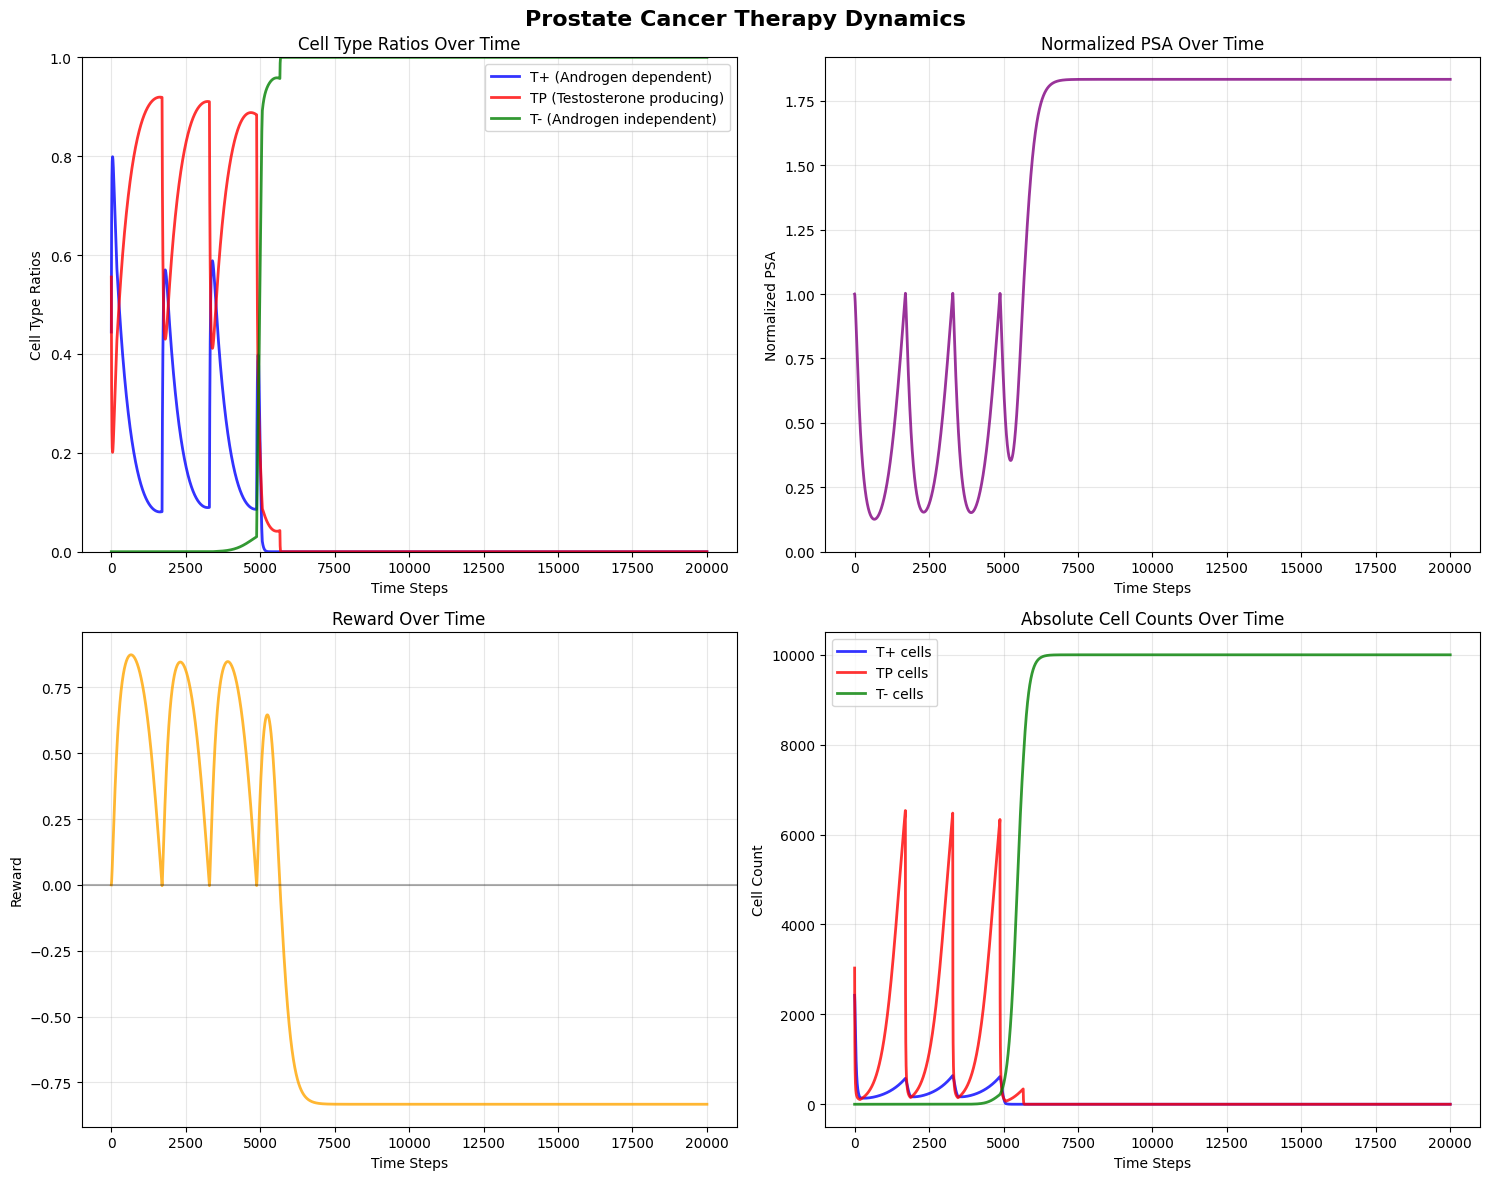


FINAL STATISTICS
Initial PSA (normalized): 1.0000
Final PSA (normalized): 1.8333
PSA change: 0.8333
Total reward: -8522.049573
Average reward per step: -0.426102
Initial population: 5455
Final population: 10000
Population change: 4545

Final cell type ratios:
  T+ ratio: 0.0000
  TP ratio: 0.0000
  T- ratio: 1.0000

Final cell counts:
  T+ cells: 0
  TP cells: 0
  T- cells: 10000

Recent PSA stability (std of last 100 steps): 0.000000
System appears to have reached equilibrium


In [65]:
# Convert to numpy arrays for easier plotting
ratios_history = np.array(ratios_history)
psa_norm_history = np.array(psa_norm_history)
rewards_history = np.array(rewards_history)
population_history = np.array(population_history)
cell_counts_history = np.array(cell_counts_history)

# Create time array
time_steps = np.arange(len(ratios_history))

# Create the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Prostate Cancer Therapy Dynamics', fontsize=16, fontweight='bold')

# Plot 1: Cell type ratios over time
ax1 = axes[0, 0]
ax1.plot(time_steps, ratios_history[:, 0], 'b-', linewidth=2, label='T+ (Androgen dependent)', alpha=0.8)
ax1.plot(time_steps, ratios_history[:, 1], 'r-', linewidth=2, label='TP (Testosterone producing)', alpha=0.8)
ax1.plot(time_steps, ratios_history[:, 2], 'g-', linewidth=2, label='T- (Androgen independent)', alpha=0.8)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Cell Type Ratios')
ax1.set_title('Cell Type Ratios Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: Normalized PSA over time
ax2 = axes[0, 1]
ax2.plot(time_steps, psa_norm_history, 'purple', linewidth=2, alpha=0.8)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Normalized PSA')
ax2.set_title('Normalized PSA Over Time')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

# Plot 3: Reward over time
ax3 = axes[1, 0]
ax3.plot(time_steps[1:], rewards_history, 'orange', linewidth=2, alpha=0.8)
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Reward')
ax3.set_title('Reward Over Time')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot 4: Absolute cell counts over time
ax4 = axes[1, 1]
ax4.plot(time_steps, cell_counts_history[:, 0], 'b-', linewidth=2, label='T+ cells', alpha=0.8)
ax4.plot(time_steps, cell_counts_history[:, 1], 'r-', linewidth=2, label='TP cells', alpha=0.8)
ax4.plot(time_steps, cell_counts_history[:, 2], 'g-', linewidth=2, label='T- cells', alpha=0.8)
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Cell Count')
ax4.set_title('Absolute Cell Counts Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)
# ax4.set_yscale('log')  # Use log scale for better visualization

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*50)
print("FINAL STATISTICS")
print("="*50)
print(f"Initial PSA (normalized): {psa_norm_history[0]:.4f}")
print(f"Final PSA (normalized): {psa_norm_history[-1]:.4f}")
print(f"PSA change: {psa_norm_history[-1] - psa_norm_history[0]:.4f}")
print(f"Total reward: {np.sum(rewards_history):.6f}")
print(f"Average reward per step: {np.mean(rewards_history):.6f}")
print(f"Initial population: {population_history[0]:.0f}")
print(f"Final population: {population_history[-1]:.0f}")
print(f"Population change: {population_history[-1] - population_history[0]:.0f}")

print("\nFinal cell type ratios:")
final_ratios = ratios_history[-1]
print(f"  T+ ratio: {final_ratios[0]:.4f}")
print(f"  TP ratio: {final_ratios[1]:.4f}")
print(f"  T- ratio: {final_ratios[2]:.4f}")

print("\nFinal cell counts:")
final_counts = cell_counts_history[-1]
print(f"  T+ cells: {final_counts[0]:.0f}")
print(f"  TP cells: {final_counts[1]:.0f}")
print(f"  T- cells: {final_counts[2]:.0f}")

# Additional analysis: Check if system reached equilibrium
if len(psa_norm_history) > 100:
    recent_psa_std = np.std(psa_norm_history[-100:])
    print(f"\nRecent PSA stability (std of last 100 steps): {recent_psa_std:.6f}")
    if recent_psa_std < 0.001:
        print("System appears to have reached equilibrium")
    else:
        print("System is still evolving")